# DT



/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/pytho

Mejores parámetros (RandomizedSearchCV): {'ccp_alpha': 0.005, 'max_depth': 30, 'max_features': 'auto', 'min_samples_leaf': 6, 'min_samples_split': 11}
Accuracy: 0.6329113924050633
AUC-ROC: 0.7063543003851092
              precision    recall  f1-score   support

     Fracaso       0.61      0.66      0.63        38
       Éxito       0.66      0.61      0.63        41

    accuracy                           0.63        79
   macro avg       0.63      0.63      0.63        79
weighted avg       0.63      0.63      0.63        79



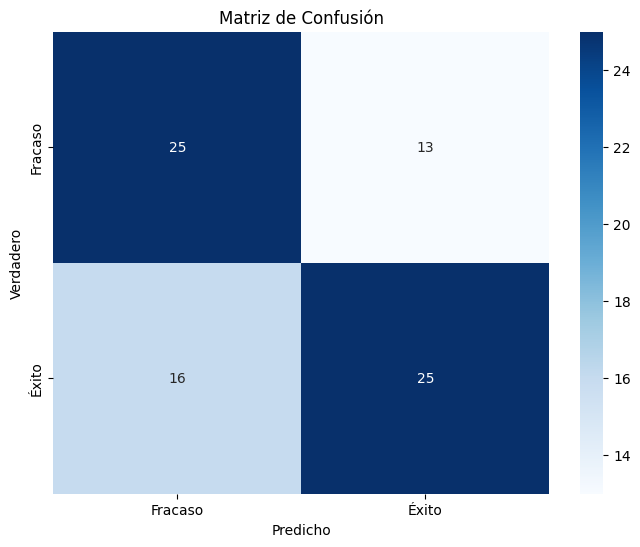

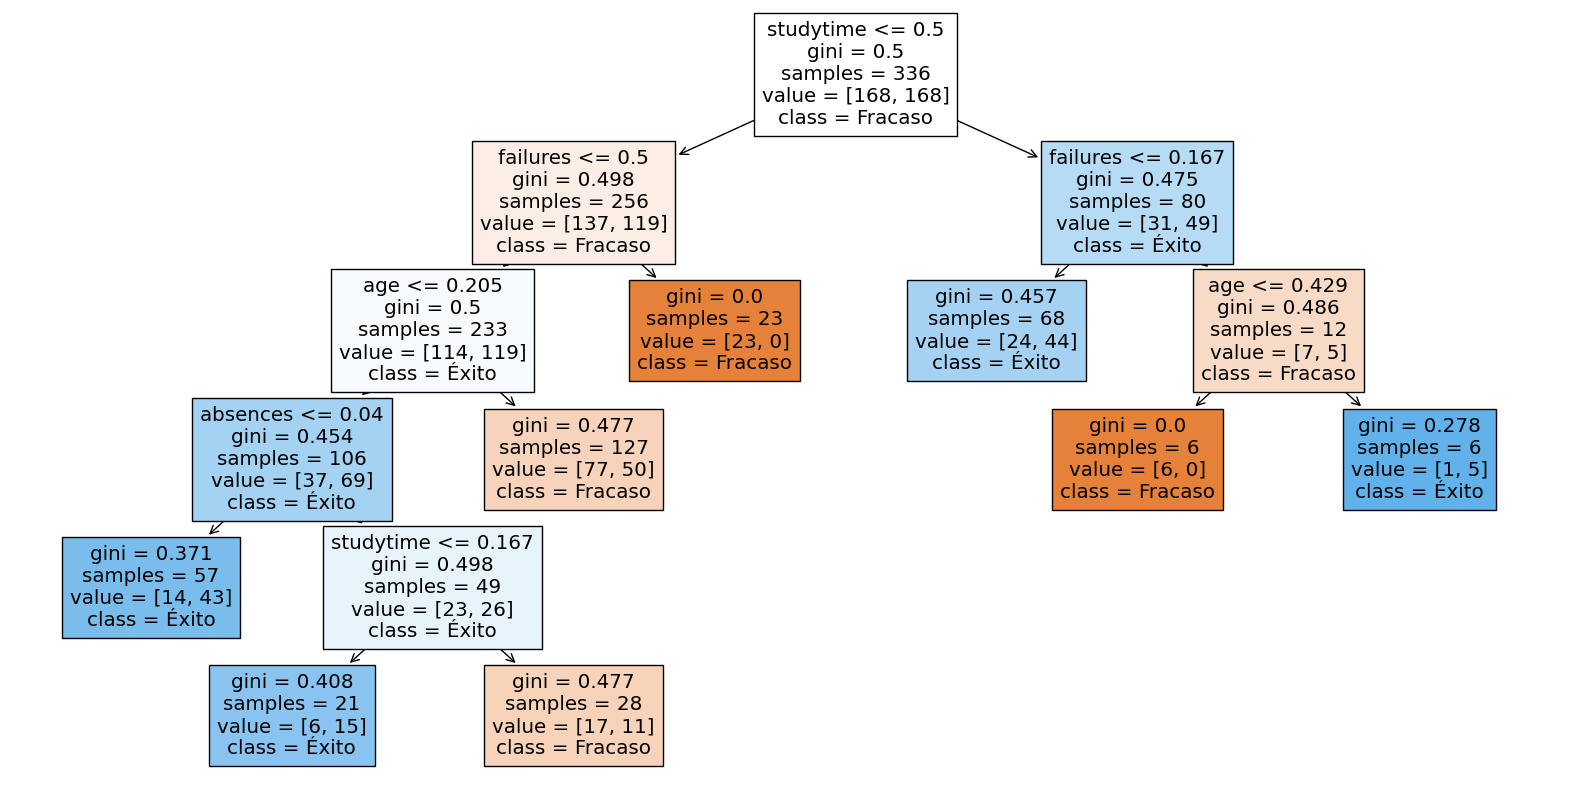

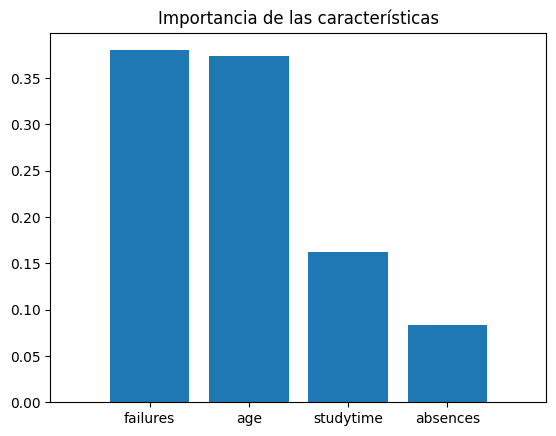

Reglas del Árbol de Decisión (con valores desescalados):
If studytime <= 2.50:
  If failures <= 1.50:
    If age <= 16.43:
      If absences <= 3.00:
        Then Éxito (probability 0.75)
      else (If absences > 3.00):
        If studytime <= 1.50:
          Then Éxito (probability 0.71)
        else (If studytime > 1.50):
          Then Fracaso (probability 0.61)
    else (If age > 16.43):
      Then Fracaso (probability 0.61)
  else (If failures > 1.50):
    Then Fracaso (probability 1.00)
else (If studytime > 2.50):
  If failures <= 0.50:
    Then Éxito (probability 0.65)
  else (If failures > 0.50):
    If age <= 18.00:
      Then Fracaso (probability 1.00)
    else (If age > 18.00):
      Then Éxito (probability 0.83)


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from scipy.stats import randint

# Cargar dataset
data = pd.read_csv('/content/drive/MyDrive/MasterThesis-IDS/dataset/student-mat.csv', delimiter=";")

# Definir éxito y preparar los datos
data['Success'] = (data['G3'] > 10).astype(int)
y = data['Success']
# Seleccionar solo las 4 características más importantes excluyendo G1 y G2
X = data[['absences', 'failures', 'studytime', 'age']]

# Normalización de los datos utilizando MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_original = X.values

# Dividir el dataset
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Balanceo de clases
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Definir los valores de parámetros a explorar para RandomizedSearchCV
param_dist = {
    'ccp_alpha': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'max_features': [None, 'auto', 'sqrt', 'log2']
}

# Inicializar el RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=DecisionTreeClassifier(random_state=42),
                                   param_distributions=param_dist,
                                   n_iter=100,
                                   cv=5,
                                   scoring='accuracy',
                                   random_state=42)

# Realizar la búsqueda de hiperparámetros
random_search.fit(X_train_smote, y_train_smote)

# Obtener los mejores parámetros
best_params_random = random_search.best_params_
print("Mejores parámetros (RandomizedSearchCV):", best_params_random)

# Entrenar el clasificador con los mejores parámetros obtenidos
clf = DecisionTreeClassifier(**best_params_random, random_state=42)
clf.fit(X_train_smote, y_train_smote)

# Evaluar el modelo
y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("AUC-ROC:", roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))
print(classification_report(y_test, y_pred, target_names=["Fracaso", "Éxito"]))

# Generar y visualizar la matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Fracaso", "Éxito"], yticklabels=["Fracaso", "Éxito"])
plt.title('Matriz de Confusión')
plt.ylabel('Verdadero')
plt.xlabel('Predicho')
plt.show()

# Visualizar el árbol de decisión
plt.figure(figsize=(20,10))
plot_tree(clf, feature_names=X.columns, class_names=["Fracaso", "Éxito"], filled=True)
plt.show()

# Importancia de las características
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure()
plt.title("Importancia de las características")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), [X.columns[i] for i in indices])
plt.xlim([-1, X.shape[1]])
plt.show()

# Función para imprimir las reglas del árbol de decisión con valores desescalados
def print_rules(tree, feature_names, class_names, scaler, depth=0):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != -2 else "undefined!"
        for i in tree_.feature
    ]

    def recurse(node, depth):
        indent = "  " * depth
        if tree_.feature[node] != -2:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            original_threshold = scaler.inverse_transform(
                [[threshold if i == tree_.feature[node] else 0 for i in range(len(feature_names))]]
            )[0][tree_.feature[node]]
            print(f"{indent}If {name} <= {original_threshold:.2f}:")
            recurse(tree_.children_left[node], depth + 1)
            print(f"{indent}else (If {name} > {original_threshold:.2f}):")
            recurse(tree_.children_right[node], depth + 1)
        else:
            value = tree_.value[node][0]
            class_idx = int(value.argmax())
            prob = value[class_idx] / value.sum()
            print(f"{indent}Then {class_names[class_idx]} (probability {prob:.2f})")

    recurse(0, depth)

# Imprimir las reglas del árbol de decisión entrenado con valores desescalados
print("Reglas del Árbol de Decisión (con valores desescalados):")
print_rules(clf, X.columns, ["Fracaso", "Éxito"], scaler)


# IDS

In [ ]:
!pip install seaborn apyori imbalanced-learn scikit-learn

  Preparing metadata (setup.py) ... done
  Created wheel for apyori: filename=apyori-1.1.2-py3-none-any.whl size=5955 sha256=a1b6c3fdb1f8a2d8b549a30887a2022a060f06249482c7412d61922ac5c5b559
  Stored in directory: /root/.cache/pip/wheels/c4/1a/79/20f55c470a50bb3702a8cb7c94d8ada15573538c7f4baebe2d
Successfully built apyori


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
2/n*n OPT value is 1355.6837098692033
Estimating omega for rule 0
Standard Error 3.719139685464906
Omega estimate is -1.0
Estimating omega for rule 1
Standard Error 3.4120375144479294
Omega estimate is -4.400000000372529
Estimating omega for rule 2
Standard Error 4.2143801442205
Omega estimate is -1.7000000001862645
Estimating omega for rule 3
Standard Error 3.9944962135418276
Omega estimate is -0.20000000018626451
Estimating omega for rule 4
Standard Error 3.3639262774323697
Omega estimate is -13.200000000186265
Estimating omega for rule 5
Standard Error 4.917723050355724
Omega estimate is 1.3999999999068677
Estimating omega for rule 6
Standard Error 4.770848981051486
Omega estimate is -2.2999999998137355
Estimating omega for rule 7
Standard Error 3.4310348293189916
Omega estimate is -10.400000000372529
Estimating omega for rule 8
Standard Error 4.6242837283

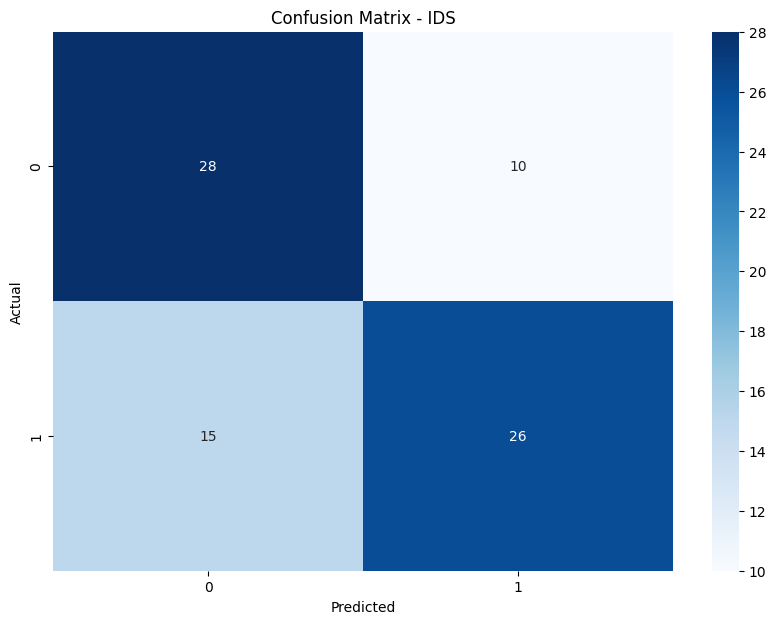

In [ ]:
import numpy as np
import pandas as pd
import math
from apyori import apriori
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from google.colab import drive

# Montar Google Drive
drive.mount('/content/drive')

# Cargar el dataset
df = pd.read_csv('/content/drive/MyDrive/MasterThesis-IDS/dataset/student-mat.csv', sep=';')

# Definir éxito y preparar los datos
df['Success'] = (df['G3'] > 10).astype(int)
Y = df['Success']
X = df[['absences', 'failures', 'studytime', 'age']]

# Normalización de los datos utilizando MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_original = X.values

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

# Balanceo de clases
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Desnormalizar los datos antes de generar reglas
X_train_smote_original = scaler.inverse_transform(X_train_smote)
X_test_original = scaler.inverse_transform(X_test)

# Clase rule
class rule:
    def __init__(self, feature_list, value_list, class_label):
        self.itemset = set()
        self.class_label = None
        self.add_item(feature_list, value_list)
        self.set_class_label(class_label)

    def add_item(self, feature_list, value_list):
        if len(feature_list) != len(value_list):
            print("Some error in inputting feature value pairs")
            return
        for i in range(len(feature_list)):
            self.itemset.add((feature_list[i], value_list[i]))

    def print_rule(self):
        s = "If "
        for item in self.itemset:
            s += str(item[0]) + " == " + str(round(float(item[1]))) + " and "
        s = s[:-5]
        s += ", then "
        s += str(self.class_label)
        print(s)

    def all_predicates_same(self, r):
        return self.itemset == r.itemset

    def class_label_same(self, r):
        return self.class_label == r.class_label

    def set_class_label(self, label):
        self.class_label = label

    def get_length(self):
        return len(self.itemset)

    def get_cover(self, df):
        dfnew = df.copy()
        for pattern in self.itemset:
            dfnew = dfnew[dfnew[pattern[0]] == pattern[1]]
        return list(dfnew.index.values)

    def get_correct_cover(self, df, Y):
        indexes_points_covered = self.get_cover(df)
        Y_arr = pd.Series(Y)
        labels_covered_points = list(Y_arr[indexes_points_covered])
        correct_cover = []
        for ind in range(len(labels_covered_points)):
            if labels_covered_points[ind] == self.class_label:
                correct_cover.append(indexes_points_covered[ind])
        return correct_cover, indexes_points_covered

    def get_incorrect_cover(self, df, Y):
        correct_cover, full_cover = self.get_correct_cover(df, Y)
        return sorted(list(set(full_cover) - set(correct_cover)))

# Función run_apriori
def run_apriori(df, support_thres):
    dataset = []
    for i in range(df.shape[0]):
        temp = []
        for col_name in df.columns:
            # Redondear los valores antes de generar los itemsets
            temp.append(col_name + "=" + str(int(round(df.iloc[i][col_name]))))
        dataset.append(temp)

    results = list(apriori(dataset, min_support=support_thres))
    list_itemsets = []
    for ele in results:
        temp = []
        for pred in ele.items:
            temp.append(pred)
        list_itemsets.append(temp)
    return list_itemsets

# Función createrules
def createrules(freq_itemsets, labels_set):
    list_of_rules = []
    for one_itemset in freq_itemsets:
        feature_list = []
        value_list = []
        for pattern in one_itemset:
            fea_val = pattern.split("=")
            feature_list.append(fea_val[0])
            value_list.append(fea_val[1])
        for each_label in labels_set:
            temp_rule = rule(feature_list, value_list, each_label)
            list_of_rules.append(temp_rule)
    return list_of_rules

# Función max_rule_length
def max_rule_length(list_rules):
    len_arr = []
    for r in list_rules:
        len_arr.append(r.get_length())
    return max(len_arr)

# Función overlap
def overlap(r1, r2, df):
    return sorted(list(set(r1.get_cover(df)).intersection(set(r2.get_cover(df)))))

# Función func_evaluation
def func_evaluation(soln_set, list_rules, df, Y, lambda_array):
    f = []
    f0 = len(list_rules) - len(soln_set)
    f.append(f0)

    Lmax = max_rule_length(list_rules)
    sum_rule_length = 0.0
    for rule_index in soln_set:
        sum_rule_length += list_rules[rule_index].get_length()
    f1 = Lmax * len(list_rules) - sum_rule_length
    f.append(f1)

    sum_overlap_intraclass = 0.0
    for r1_index in soln_set:
        for r2_index in soln_set:
            if r1_index >= r2_index:
                continue
            if list_rules[r1_index].class_label == list_rules[r2_index].class_label:
                sum_overlap_intraclass += len(overlap(list_rules[r1_index], list_rules[r2_index], df))
    f2 = df.shape[0] * len(list_rules) * len(list_rules) - sum_overlap_intraclass
    f.append(f2)

    sum_overlap_interclass = 0.0
    for r1_index in soln_set:
        for r2_index in soln_set:
            if r1_index >= r2_index:
                continue
            if list_rules[r1_index].class_label != list_rules[r2_index].class_label:
                sum_overlap_interclass += len(overlap(list_rules[r1_index], list_rules[r2_index], df))
    f3 = df.shape[0] * len(list_rules) * len(list_rules) - sum_overlap_interclass
    f.append(f3)

    classes_covered = set()
    for index in soln_set:
        classes_covered.add(list_rules[index].class_label)
    f4 = len(classes_covered)
    f.append(f4)

    sum_incorrect_cover = 0.0
    for index in soln_set:
        sum_incorrect_cover += len(list_rules[index].get_incorrect_cover(df, Y))
    f5 = df.shape[0] * len(list_rules) - sum_incorrect_cover
    f.append(f5)

    atleast_once_correctly_covered = set()
    for index in soln_set:
        correct_cover, full_cover = list_rules[index].get_correct_cover(df, Y)
        atleast_once_correctly_covered = atleast_once_correctly_covered.union(set(correct_cover))
    f6 = len(atleast_once_correctly_covered)
    f.append(f6)

    obj_val = 0.0
    for i in range(7):
        obj_val += f[i] * lambda_array[i]

    return obj_val

# Función sample_random_set
def sample_random_set(soln_set, delta, len_list_rules):
    all_rule_indexes = set(range(len_list_rules))
    return_set = set()

    p = (delta + 1.0) / 2
    for item in soln_set:
        random_val = np.random.uniform()
        if random_val <= p:
            return_set.add(item)

    p_prime = (1.0 - delta) / 2
    for item in (all_rule_indexes - soln_set):
        random_val = np.random.uniform()
        if random_val <= p_prime:
            return_set.add(item)

    return return_set

# Función estimate_omega_for_element
def estimate_omega_for_element(soln_set, delta, rule_x_index, list_rules, df, Y, lambda_array, error_threshold):
    Exp1_func_vals = []
    Exp2_func_vals = []

    while True:
        for i in range(10):
            temp_soln_set = sample_random_set(soln_set, delta, len(list_rules))
            temp_soln_set.add(rule_x_index)
            Exp1_func_vals.append(func_evaluation(temp_soln_set, list_rules, df, Y, lambda_array))

        for j in range(10):
            temp_soln_set = sample_random_set(soln_set, delta, len(list_rules))
            if rule_x_index in temp_soln_set:
                temp_soln_set.remove(rule_x_index)
            Exp2_func_vals.append(func_evaluation(temp_soln_set, list_rules, df, Y, lambda_array))

        variance_Exp1 = np.var(Exp1_func_vals, dtype=np.float64)
        variance_Exp2 = np.var(Exp2_func_vals, dtype=np.float64)
        std_err = math.sqrt(variance_Exp1 / len(Exp1_func_vals) + variance_Exp2 / len(Exp2_func_vals))
        print("Standard Error " + str(std_err))

        if std_err <= error_threshold:
            break

    return np.mean(Exp1_func_vals) - np.mean(Exp2_func_vals)

# Función compute_OPT
def compute_OPT(list_rules, df, Y, lambda_array):
    opt_set = set()
    for i in range(len(list_rules)):
        r_val = np.random.uniform()
        if r_val <= 0.5:
            opt_set.add(i)
    return func_evaluation(opt_set, list_rules, df, Y, lambda_array)

# Función smooth_local_search
def smooth_local_search(list_rules, df, Y, lambda_array, delta, delta_prime):
    n = len(list_rules)
    OPT = compute_OPT(list_rules, df, Y, lambda_array)
    print("2/n*n OPT value is " + str(2.0 / (n * n) * OPT))

    soln_set = set()
    restart_omega_computations = False

    while True:
        omega_estimates = []
        for rule_x_index in range(n):
            print("Estimating omega for rule " + str(rule_x_index))
            omega_est = estimate_omega_for_element(soln_set, delta, rule_x_index, list_rules, df, Y, lambda_array, 1.0 / (n * n) * OPT)
            omega_estimates.append(omega_est)
            print("Omega estimate is " + str(omega_est))

            if rule_x_index in soln_set:
                continue

            if omega_est > 2.0 / (n * n) * OPT:
                soln_set.add(rule_x_index)
                restart_omega_computations = True
                print("-----------------------")
                print("Adding to the solution set rule " + str(rule_x_index))
                print("-----------------------")
                break

        if restart_omega_computations:
            restart_omega_computations = False
            continue

        for rule_ind in soln_set:
            if omega_estimates[rule_ind] < -2.0 / (n * n) * OPT:
                soln_set.remove(rule_ind)
                restart_omega_computations = True
                print("Removing from the solution set rule " + str(rule_ind))
                break

        if restart_omega_computations:
            restart_omega_computations = False
            continue

        return sample_random_set(soln_set, delta_prime, n)

# Función para predecir usando las reglas seleccionadas
def predict(X, rules):
    predictions = []
    for i in range(X.shape[0]):
        matched_rules = []
        for rule in rules:
            rule_matched = True
            for pattern in rule.itemset:
                col_name, feature_val = pattern
                feature_val = int(feature_val)  # Asegurarse que el valor sea un entero
                if int(round(X.iloc[i][col_name])) != feature_val:
                    rule_matched = False
                    break
            if rule_matched:
                matched_rules.append(rule)
        if matched_rules:
            predictions.append(max(matched_rules, key=lambda r: r.class_label).class_label)
        else:
            predictions.append(0)  # Predicción por defecto si no se encuentra ninguna regla
    return predictions

# Ejecutar Apriori para obtener itemsets frecuentes
itemsets = run_apriori(pd.DataFrame(X_train_smote_original, columns=['absences', 'failures', 'studytime', 'age']), 0.1)  # Ajuste del soporte mínimo
list_of_rules = createrules(itemsets, list(set(y_train_smote)))

# Evaluar las reglas
lambda_array = [1.0] * 7
s1 = smooth_local_search(list_of_rules, pd.DataFrame(X_train_smote_original, columns=['absences', 'failures', 'studytime', 'age']), y_train_smote, lambda_array, 0.33, 0.33)
s2 = smooth_local_search(list_of_rules, pd.DataFrame(X_train_smote_original, columns=['absences', 'failures', 'studytime', 'age']), y_train_smote, lambda_array, 0.33, -1.0)
f1 = func_evaluation(s1, list_of_rules, pd.DataFrame(X_train_smote_original, columns=['absences', 'failures', 'studytime', 'age']), y_train_smote, lambda_array)
f2 = func_evaluation(s2, list_of_rules, pd.DataFrame(X_train_smote_original, columns=['absences', 'failures', 'studytime', 'age']), y_train_smote, lambda_array)
solution_set = s1 if f1 > f2 else s2
print("The Solution Set is: " + str(solution_set))

# Función para encontrar reglas contradictorias
def find_contradictory_rules(solution_set, list_of_rules):
    contradictions = []
    checked_rules = set()
    for i in solution_set:
        rule_i = list_of_rules[i]
        for j in solution_set:
            if i == j or (j, i) in checked_rules:
                continue
            rule_j = list_of_rules[j]
            if rule_i.all_predicates_same(rule_j) and not rule_i.class_label_same(rule_j):
                contradictions.append((i, j))
            checked_rules.add((i, j))
    return contradictions

# Eliminar reglas contradictorias del conjunto de soluciones
def remove_contradictory_rules(solution_set, list_of_rules):
    contradictions = find_contradictory_rules(solution_set, list_of_rules)
    removed_rules = set()
    iteration = 0
    while contradictions:
        iteration += 1
        print(f"Iteration {iteration}, solution set size: {len(solution_set)}, contradictions found: {len(contradictions)}")
        for r1_index, r2_index in contradictions:
            # Eliminar una de las reglas contradictorias
            if r1_index in solution_set and r2_index in solution_set:
                if list_of_rules[r1_index].get_length() > list_of_rules[r2_index].get_length():
                    solution_set.remove(r1_index)
                    removed_rules.add(r1_index)
                else:
                    solution_set.remove(r2_index)
                    removed_rules.add(r2_index)
        contradictions = [pair for pair in find_contradictory_rules(solution_set, list_of_rules) if pair[0] not in removed_rules and pair[1] not in removed_rules]
    return solution_set

# Eliminar reglas contradictorias del conjunto de soluciones
solution_set = remove_contradictory_rules(solution_set, list_of_rules)

# Imprimir las reglas seleccionadas
print("\nSelected Rules:")
for rule_index in solution_set:
    list_of_rules[rule_index].print_rule()

# Verificar reglas contradictorias
contradictions = find_contradictory_rules(solution_set, list_of_rules)
if contradictions:
    print("\nContradictory Rules Found:")
    for r1_index, r2_index in contradictions:
        list_of_rules[r1_index].print_rule()
        list_of_rules[r2_index].print_rule()
        print()
else:
    print("\nNo Contradictory Rules Found.")

# Realizar predicciones con el conjunto de reglas seleccionado
y_pred = predict(pd.DataFrame(X_test_original, columns=['absences', 'failures', 'studytime', 'age']), [list_of_rules[index] for index in solution_set])

# Verificar las predicciones
print("Predictions:", y_pred)
print("True Labels:", list(y_test))

# Evaluar las métricas de desempeño
print("\nMétricas de desempeño para IDS:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Mostrar la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - IDS')
plt.show()


# Other models

Downloading...
From: https://drive.google.com/uc?id=1U9CMXc3Lh7CHvajjfDvNkXr9kKS3443o
To: /content/student-mat.csv
100%|██████████| 57.0k/57.0k [00:00<00:00, 53.2MB/s]


Dimensiones de X_train_smote: (336, 4)
Dimensiones de y_train_smote: (336,)
Dimensiones de X_test: (79, 4)
Dimensiones de y_test: (79,)


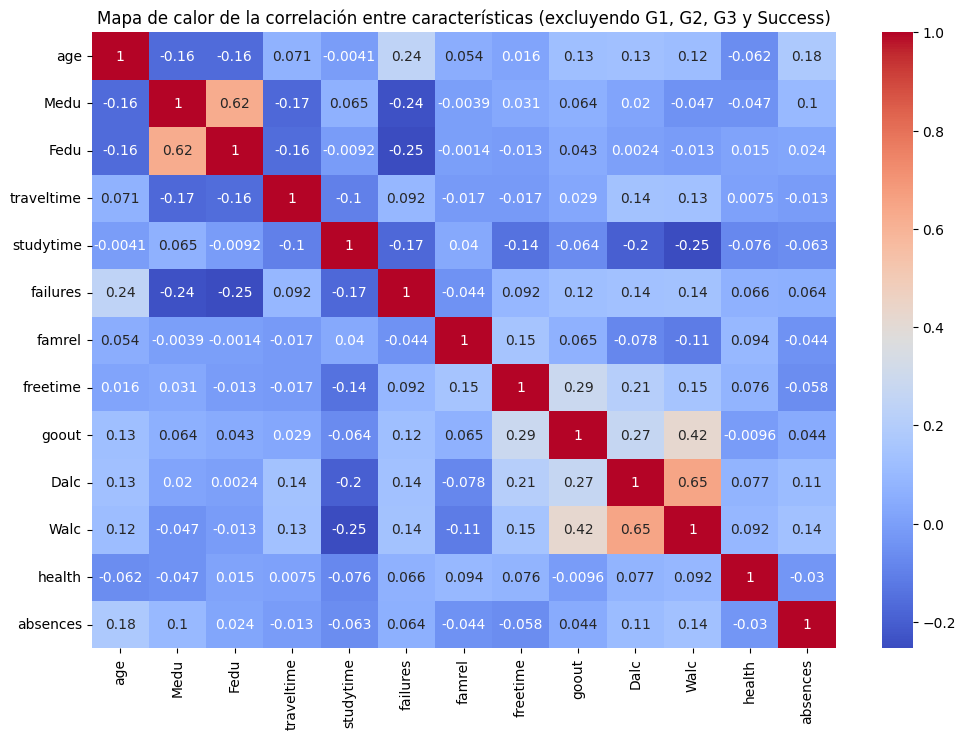

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomFor

Mejores parámetros (RandomizedSearchCV - Random Forest): {'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 18, 'n_estimators': 87}
Random Forest - Accuracy: 0.6456, AUC-ROC: 0.6842
              precision    recall  f1-score   support

     Fracaso       0.66      0.55      0.60        38
       Éxito       0.64      0.73      0.68        41

    accuracy                           0.65        79
   macro avg       0.65      0.64      0.64        79
weighted avg       0.65      0.65      0.64        79



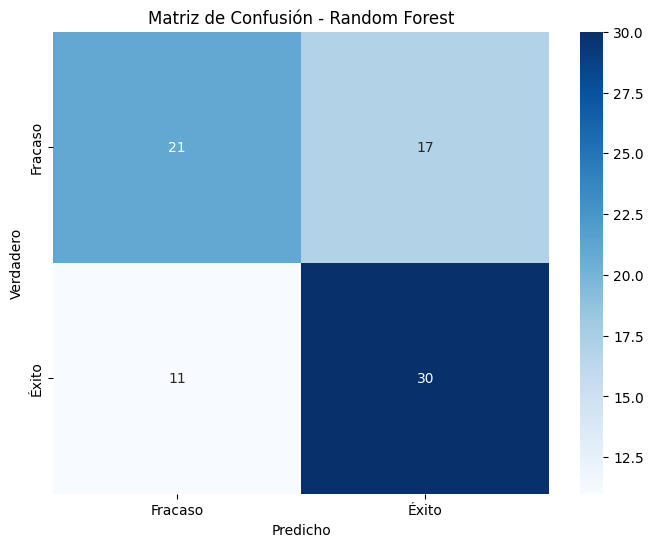

Reglas del árbol 1 en el Random Forest:
|--- failures <= 0.17
|   |--- age <= 0.18
|   |   |--- absences <= 0.04
|   |   |   |--- absences <= 0.02
|   |   |   |   |--- class: 1.0
|   |   |   |--- absences >  0.02
|   |   |   |   |--- age <= 0.07
|   |   |   |   |   |--- class: 1.0
|   |   |   |   |--- age >  0.07
|   |   |   |   |   |--- class: 1.0
|   |   |--- absences >  0.04
|   |   |   |--- studytime <= 0.17
|   |   |   |   |--- class: 1.0
|   |   |   |--- studytime >  0.17
|   |   |   |   |--- absences <= 0.10
|   |   |   |   |   |--- class: 0.0
|   |   |   |   |--- absences >  0.10
|   |   |   |   |   |--- class: 0.0
|   |--- age >  0.18
|   |   |--- studytime <= 0.17
|   |   |   |--- class: 0.0
|   |   |--- studytime >  0.17
|   |   |   |--- age <= 0.36
|   |   |   |   |--- class: 1.0
|   |   |   |--- age >  0.36
|   |   |   |   |--- studytime <= 0.50
|   |   |   |   |   |--- class: 0.0
|   |   |   |   |--- studytime >  0.50
|   |   |   |   |   |--- class: 0.0
|--- failures >  0

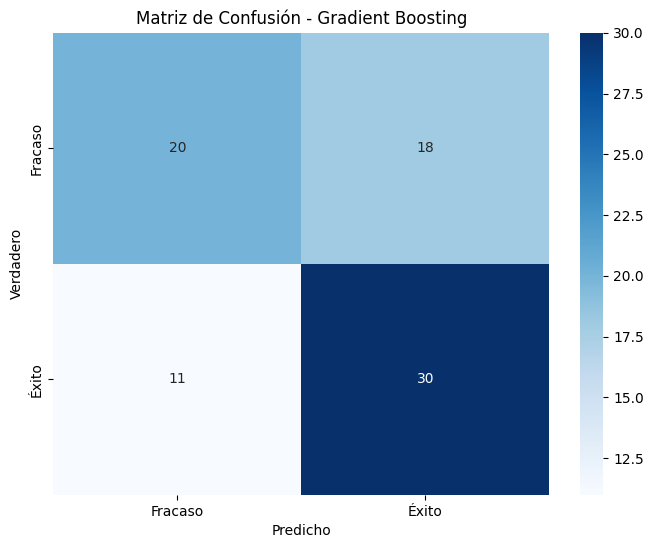

Reglas del árbol 1 en el Gradient Boosting:
|--- failures <= 0.17
|   |--- age <= 0.18
|   |   |--- absences <= 0.04
|   |   |   |--- value: [0.88]
|   |   |--- absences >  0.04
|   |   |   |--- value: [0.32]
|   |--- age >  0.18
|   |   |--- studytime <= 0.50
|   |   |   |--- value: [-0.29]
|   |   |--- studytime >  0.50
|   |   |   |--- value: [0.63]
|--- failures >  0.17
|   |--- absences <= 0.03
|   |   |--- failures <= 0.50
|   |   |   |--- value: [-1.33]
|   |   |--- failures >  0.50
|   |   |   |--- value: [-2.00]
|   |--- absences >  0.03
|   |   |--- studytime <= 0.50
|   |   |   |--- value: [-0.78]
|   |   |--- studytime >  0.50
|   |   |   |--- value: [0.86]

Reglas del árbol 2 en el Gradient Boosting:
|--- failures <= 0.17
|   |--- age <= 0.18
|   |   |--- absences <= 0.04
|   |   |   |--- value: [0.87]
|   |   |--- absences >  0.04
|   |   |   |--- value: [0.31]
|   |--- age >  0.18
|   |   |--- studytime <= 0.50
|   |   |   |--- value: [-0.28]
|   |   |--- studytime >  0.

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 80 is smaller than n_iter=100. Running 80 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_p

Mejores parámetros (RandomizedSearchCV - Neural Network): {'solver': 'sgd', 'learning_rate': 'adaptive', 'hidden_layer_sizes': (50,), 'alpha': 0.0001, 'activation': 'relu'}
Neural Network - Accuracy: 0.5823, AUC-ROC: 0.6900
              precision    recall  f1-score   support

     Fracaso       0.55      0.76      0.64        38
       Éxito       0.65      0.41      0.51        41

    accuracy                           0.58        79
   macro avg       0.60      0.59      0.57        79
weighted avg       0.60      0.58      0.57        79



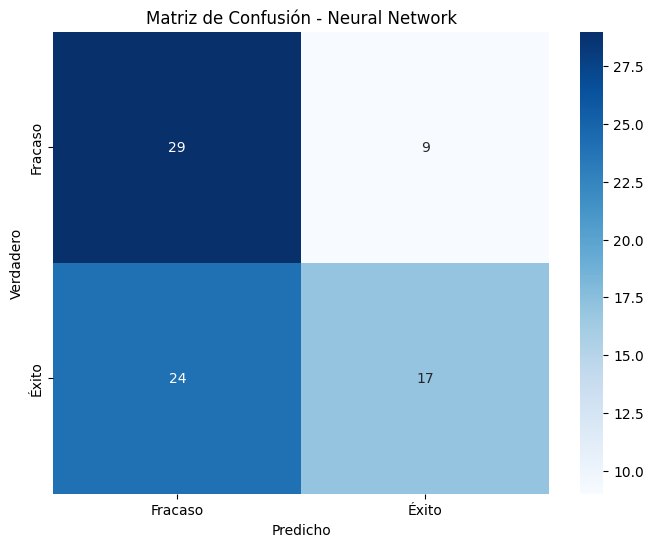

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 16 is smaller than n_iter=100. Running 16 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Mejores parámetros (RandomizedSearchCV - Logistic Regression): {'solver': 'saga', 'penalty': 'l1', 'C': 1.0}
Logistic Regression - Accuracy: 0.6962, AUC-ROC: 0.6598
              precision    recall  f1-score   support

     Fracaso       0.89      0.42      0.57        38
       Éxito       0.64      0.95      0.76        41

    accuracy                           0.70        79
   macro avg       0.76      0.69      0.67        79
weighted avg       0.76      0.70      0.67        79



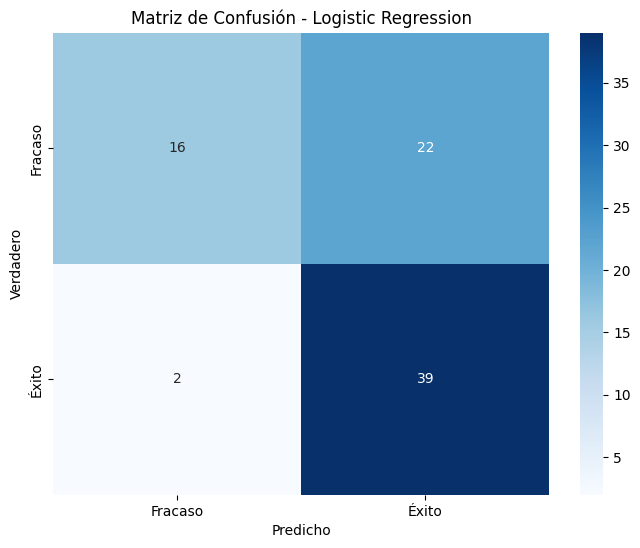

Random Forest - Mean Accuracy: 0.6068 ± 0.0847, Mean AUC-ROC: 0.6495 ± 0.0648
Gradient Boosting - Mean Accuracy: 0.5565 ± 0.0625, Mean AUC-ROC: 0.6164 ± 0.0664
Neural Network - Mean Accuracy: 0.5686 ± 0.0788, Mean AUC-ROC: 0.6683 ± 0.0868
Logistic Regression - Mean Accuracy: 0.6190 ± 0.0525, Mean AUC-ROC: 0.6593 ± 0.0882
Evaluación de otros modelos completada.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from scipy.stats import randint
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
import gdown
from sklearn.tree import export_text

# Descargar el archivo
file_id = '1U9CMXc3Lh7CHvajjfDvNkXr9kKS3443o'
url = f'https://drive.google.com/uc?id={file_id}'
output = 'student-mat.csv'
gdown.download(url, output, quiet=False)

# Cargar dataset
data = pd.read_csv(output, delimiter=";")

# Definir éxito y preparar los datos
data['Success'] = (data['G3'] > 10).astype(int)
y = data['Success']
X = data[['absences', 'failures', 'studytime', 'age']]

# Normalización de los datos utilizando MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_original = X.values

# Dividir el dataset
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Balanceo de clases
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Verificar las dimensiones de los datos
print(f"Dimensiones de X_train_smote: {X_train_smote.shape}")
print(f"Dimensiones de y_train_smote: {y_train_smote.shape}")
print(f"Dimensiones de X_test: {X_test.shape}")
print(f"Dimensiones de y_test: {y_test.shape}")

# Generar la matriz de correlación excluyendo G1, G2, G3 y Success
data_excl = data.drop(columns=['G1', 'G2', 'G3', 'Success'])
data_excl_numeric = data_excl.select_dtypes(include=[np.number])
correlation_matrix_excl = data_excl_numeric.corr()

# Generar el mapa de calor
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix_excl, annot=True, cmap='coolwarm')
plt.title('Mapa de calor de la correlación entre características (excluyendo G1, G2, G3 y Success)')
plt.show()

# Definir los valores de parámetros a explorar para RandomizedSearchCV para Random Forest
param_dist_rf = {
    'n_estimators': randint(50, 200),
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['auto', 'sqrt', 'log2']
}

# Inicializar el RandomizedSearchCV para Random Forest
random_search_rf = RandomizedSearchCV(estimator=RandomForestClassifier(random_state=42),
                                      param_distributions=param_dist_rf,
                                      n_iter=100,
                                      cv=5,
                                      scoring='roc_auc',
                                      random_state=42)

# Realizar la búsqueda de hiperparámetros para Random Forest
random_search_rf.fit(X_train_smote, y_train_smote)

# Obtener los mejores parámetros
best_params_rf = random_search_rf.best_params_
print("Mejores parámetros (RandomizedSearchCV - Random Forest):", best_params_rf)

# Entrenar el clasificador con los mejores parámetros obtenidos
clf_rf = RandomForestClassifier(**best_params_rf, random_state=42)
clf_rf.fit(X_train_smote, y_train_smote)

# Evaluar el modelo Random Forest
y_pred_rf = clf_rf.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
auc_roc_rf = roc_auc_score(y_test, clf_rf.predict_proba(X_test)[:, 1])

print(f"Random Forest - Accuracy: {accuracy_rf:.4f}, AUC-ROC: {auc_roc_rf:.4f}")
print(classification_report(y_test, y_pred_rf, target_names=["Fracaso", "Éxito"]))

# Generar y visualizar la matriz de confusión
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', xticklabels=["Fracaso", "Éxito"], yticklabels=["Fracaso", "Éxito"])
plt.title('Matriz de Confusión - Random Forest')
plt.ylabel('Verdadero')
plt.xlabel('Predicho')
plt.show()

# Extraer y mostrar reglas de los árboles en el Random Forest
for i, tree in enumerate(clf_rf.estimators_[:3]):  # Mostramos solo los primeros 3 árboles
    print(f"Reglas del árbol {i+1} en el Random Forest:")
    tree_rules = export_text(tree, feature_names=list(X.columns))
    print(tree_rules)

# Evaluación del modelo Gradient Boosting
param_dist_gb = {
    'n_estimators': randint(50, 200),
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1, 0.2, 0.3]
}

random_search_gb = RandomizedSearchCV(estimator=GradientBoostingClassifier(random_state=42),
                                      param_distributions=param_dist_gb,
                                      n_iter=100,
                                      cv=5,
                                      scoring='roc_auc',
                                      random_state=42)

# Realizar la búsqueda de hiperparámetros para Gradient Boosting
random_search_gb.fit(X_train_smote, y_train_smote)

# Obtener los mejores parámetros
best_params_gb = random_search_gb.best_params_
print("Mejores parámetros (RandomizedSearchCV - Gradient Boosting):", best_params_gb)

# Entrenar el clasificador con los mejores parámetros obtenidos
clf_gb = GradientBoostingClassifier(**best_params_gb, random_state=42)
clf_gb.fit(X_train_smote, y_train_smote)

# Evaluar el modelo Gradient Boosting
y_pred_gb = clf_gb.predict(X_test)
accuracy_gb = accuracy_score(y_test, y_pred_gb)
auc_roc_gb = roc_auc_score(y_test, clf_gb.predict_proba(X_test)[:, 1])

print(f"Gradient Boosting - Accuracy: {accuracy_gb:.4f}, AUC-ROC: {auc_roc_gb:.4f}")
print(classification_report(y_test, y_pred_gb, target_names=["Fracaso", "Éxito"]))

# Generar y visualizar la matriz de confusión
cm_gb = confusion_matrix(y_test, y_pred_gb)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_gb, annot=True, fmt='d', cmap='Blues', xticklabels=["Fracaso", "Éxito"], yticklabels=["Fracaso", "Éxito"])
plt.title('Matriz de Confusión - Gradient Boosting')
plt.ylabel('Verdadero')
plt.xlabel('Predicho')
plt.show()

# Extraer y mostrar reglas de los árboles en el Gradient Boosting
for i, tree in enumerate(clf_gb.estimators_[:, 0][:3]):  # Mostramos solo los primeros 3 árboles
    print(f"Reglas del árbol {i+1} en el Gradient Boosting:")
    tree_rules = export_text(tree, feature_names=list(X.columns))
    print(tree_rules)

# Evaluación del modelo Neural Network
param_dist_nn = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50), (100, 100)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant', 'adaptive']
}

random_search_nn = RandomizedSearchCV(estimator=MLPClassifier(max_iter=500, random_state=42),
                                      param_distributions=param_dist_nn,
                                      n_iter=100,
                                      cv=5,
                                      scoring='roc_auc',
                                      random_state=42)

# Realizar la búsqueda de hiperparámetros para Neural Network
random_search_nn.fit(X_train_smote, y_train_smote)

# Obtener los mejores parámetros
best_params_nn = random_search_nn.best_params_
print("Mejores parámetros (RandomizedSearchCV - Neural Network):", best_params_nn)

# Entrenar el clasificador con los mejores parámetros obtenidos
clf_nn = MLPClassifier(**best_params_nn, max_iter=500, random_state=42)
clf_nn.fit(X_train_smote, y_train_smote)

# Evaluar el modelo Neural Network
y_pred_nn = clf_nn.predict(X_test)
accuracy_nn = accuracy_score(y_test, y_pred_nn)
auc_roc_nn = roc_auc_score(y_test, clf_nn.predict_proba(X_test)[:, 1])

print(f"Neural Network - Accuracy: {accuracy_nn:.4f}, AUC-ROC: {auc_roc_nn:.4f}")
print(classification_report(y_test, y_pred_nn, target_names=["Fracaso", "Éxito"]))

# Generar y visualizar la matriz de confusión
cm_nn = confusion_matrix(y_test, y_pred_nn)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_nn, annot=True, fmt='d', cmap='Blues', xticklabels=["Fracaso", "Éxito"], yticklabels=["Fracaso", "Éxito"])
plt.title('Matriz de Confusión - Neural Network')
plt.ylabel('Verdadero')
plt.xlabel('Predicho')
plt.show()

# Evaluación del modelo Logistic Regression
param_dist_lr = {
    'penalty': ['l1', 'l2'],
    'C': [0.1, 1.0, 10.0, 100.0],
    'solver': ['liblinear', 'saga']
}

random_search_lr = RandomizedSearchCV(estimator=LogisticRegression(random_state=42, max_iter=500),
                                      param_distributions=param_dist_lr,
                                      n_iter=100,
                                      cv=5,
                                      scoring='roc_auc',
                                      random_state=42)

# Realizar la búsqueda de hiperparámetros para Logistic Regression
random_search_lr.fit(X_train_smote, y_train_smote)

# Obtener los mejores parámetros
best_params_lr = random_search_lr.best_params_
print("Mejores parámetros (RandomizedSearchCV - Logistic Regression):", best_params_lr)

# Entrenar el clasificador con los mejores parámetros obtenidos
clf_lr = LogisticRegression(**best_params_lr, random_state=42, max_iter=500)
clf_lr.fit(X_train_smote, y_train_smote)

# Evaluar el modelo Logistic Regression
y_pred_lr = clf_lr.predict(X_test)
accuracy_lr = accuracy_score(y_test, y_pred_lr)
auc_roc_lr = roc_auc_score(y_test, clf_lr.predict_proba(X_test)[:, 1])

print(f"Logistic Regression - Accuracy: {accuracy_lr:.4f}, AUC-ROC: {auc_roc_lr:.4f}")
print(classification_report(y_test, y_pred_lr, target_names=["Fracaso", "Éxito"]))

# Generar y visualizar la matriz de confusión
cm_lr = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', xticklabels=["Fracaso", "Éxito"], yticklabels=["Fracaso", "Éxito"])
plt.title('Matriz de Confusión - Logistic Regression')
plt.ylabel('Verdadero')
plt.xlabel('Predicho')
plt.show()

# Función para evaluar modelos con validación cruzada
def evaluate_model_with_cv(model, X, y, kf):
    accuracies = []
    auc_rocs = []
    for train_index, val_index in kf.split(X, y):
        X_train_fold, X_val_fold = X[train_index], X[val_index]
        y_train_fold, y_val_fold = y[train_index], y[val_index]

        # Entrenar el modelo
        model.fit(X_train_fold, y_train_fold)

        # Evaluar el modelo
        y_pred_fold = model.predict(X_val_fold)
        accuracy = accuracy_score(y_val_fold, y_pred_fold)
        auc_roc = roc_auc_score(y_val_fold, model.predict_proba(X_val_fold)[:, 1])

        accuracies.append(accuracy)
        auc_rocs.append(auc_roc)

    return np.mean(accuracies), np.std(accuracies), np.mean(auc_rocs), np.std(auc_rocs)

# Validación cruzada
kf = StratifiedKFold(n_splits=5)

# Evaluar modelos con validación cruzada
models = {
    'Random Forest': clf_rf,
    'Gradient Boosting': clf_gb,
    'Neural Network': clf_nn,
    'Logistic Regression': clf_lr
}

for name, model in models.items():
    mean_accuracy, std_accuracy, mean_auc_roc, std_auc_roc = evaluate_model_with_cv(model, X_train_smote, y_train_smote, kf)
    print(f"{name} - Mean Accuracy: {mean_accuracy:.4f} ± {std_accuracy:.4f}, Mean AUC-ROC: {mean_auc_roc:.4f} ± {std_auc_roc:.4f}")

print("Evaluación de otros modelos completada.")
